# Dependências

In [2]:
!nvidia-smi

Fri Dec 22 21:07:36 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
!pip3 install torch torchvision torchaudio torchviz

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchviz import make_dot

from IPython.display import Image

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# Dados

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CNN
CONV -> CONV->   POOL -> CONV -> POOL - > FC

## Arquitetura

In [91]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    # in_channel: 3, out_channel: 6, kernel_size: 5, stride: 1
    self.conv1 = nn.Conv2d(3, 6, 5)
    # 32x32x3 -> 28x28x6

    # in_channel: 6, out_channel 16, kernel_size: 5, stride: 1
    self.conv2 = nn.Conv2d(6, 16, 5)
    # 28x28x6 -> 24x24x16

    # kernel_size: 2, stride: kernel_size
    self.pool1 = nn.MaxPool2d(2)
    # 24x24x16 -> 12x12x16

    # in_channel: 16, out_channel: 24, kernel_size: 5, stride: 1
    self.conv3 = nn.Conv2d(16, 24, 5)
    # 12x12x16 -> 8x8x24

    # kernel_size: 2, stride: kernel_size
    self.pool2 = nn.MaxPool2d(2)
    # 8x8x24 -> 4x4x24

    self.fc = nn.Linear(4 * 4 * 24, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool1(x)
    x = F.relu(self.conv3(x))
    x = self.pool2(x)

    x = torch.flatten(x, 1) # flatten all dimensions except batch

    x = self.fc(x)
    return x

net = Net().to(device)

In [92]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=384, out_features=10, bias=True)
)

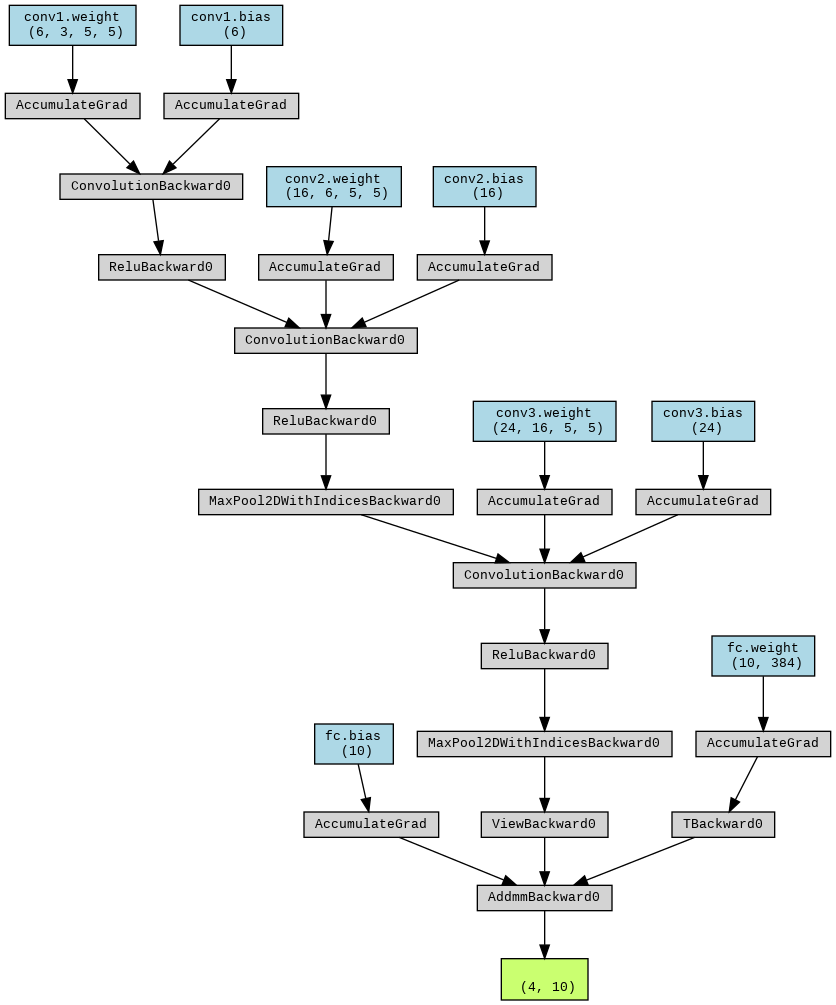

In [93]:
inputs, labels = next(iter(trainloader))
inputs = inputs.to(device)
yhat = net(inputs)

make_dot(yhat, params=dict(list(net.named_parameters()))).render("cnn_torchviz", format="png")

Image(open("cnn_torchviz.png","rb").read())

## Treino e Teste

In [94]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [95]:
EPOCHS = 20

epoch_losses = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times

  running_loss = 0.0
  epoch_loss = 0.0

  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    epoch_loss += outputs.shape[0] * loss.item()
    if i % 2000 == 1999:    # print every 2000 mini-batches
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
      running_loss = 0.0

  epoch_loss_mean = epoch_loss / len(trainset)
  print(f"[epoch {epoch + 1}] loss: {epoch_loss_mean:.3f}")
  epoch_losses.append(epoch_loss_mean)

print('Finished Training')

[1,  2000] loss: 2.067
[1,  4000] loss: 1.728
[1,  6000] loss: 1.588
[1,  8000] loss: 1.492
[1, 10000] loss: 1.455
[1, 12000] loss: 1.415
[epoch 1] loss: 1.615
[2,  2000] loss: 1.338
[2,  4000] loss: 1.325
[2,  6000] loss: 1.302
[2,  8000] loss: 1.278
[2, 10000] loss: 1.272
[2, 12000] loss: 1.247
[epoch 2] loss: 1.291
[3,  2000] loss: 1.173
[3,  4000] loss: 1.171
[3,  6000] loss: 1.178
[3,  8000] loss: 1.145
[3, 10000] loss: 1.156
[3, 12000] loss: 1.160
[epoch 3] loss: 1.166
[4,  2000] loss: 1.101
[4,  4000] loss: 1.114
[4,  6000] loss: 1.108
[4,  8000] loss: 1.069
[4, 10000] loss: 1.106
[4, 12000] loss: 1.108
[epoch 4] loss: 1.102
[5,  2000] loss: 1.034
[5,  4000] loss: 1.037
[5,  6000] loss: 1.049
[5,  8000] loss: 1.082
[5, 10000] loss: 1.084
[5, 12000] loss: 1.048
[epoch 5] loss: 1.057
[6,  2000] loss: 1.025
[6,  4000] loss: 1.034
[6,  6000] loss: 1.025
[6,  8000] loss: 1.023
[6, 10000] loss: 1.022
[6, 12000] loss: 1.046
[epoch 6] loss: 1.030
[7,  2000] loss: 0.980
[7,  4000] loss: 

([<matplotlib.axis.XTick at 0x7f402286ae60>,
 [Text(1, 0, '1'),
  Text(3, 0, '3'),
  Text(5, 0, '5'),
  Text(7, 0, '7'),
  Text(9, 0, '9'),
  Text(11, 0, '11'),
  Text(13, 0, '13'),
  Text(15, 0, '15'),
  Text(17, 0, '17'),
  Text(19, 0, '19')])

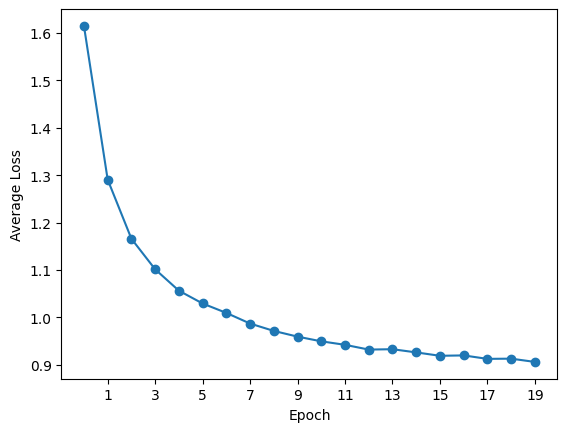

In [98]:
plt.plot(range(EPOCHS), epoch_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.xticks(range(1, EPOCHS+1, 2))

In [120]:
cnn_statistics = pd.DataFrame({"epoch": range(EPOCHS), "average_loss": epoch_losses})
cnn_statistics.to_csv("cnn_stats.csv", index=False)
cnn_statistics

,epoch,average_loss
0,0,1.615001
1,1,1.290811
2,2,1.166095
3,3,1.101656
4,4,1.056550
5,5,1.029538
6,6,1.009663
7,7,0.987224
8,8,0.971674
9,9,0.959623


In [107]:
PATH = './cifar_cnn-net.pth'
torch.save(net.state_dict(), PATH)

In [109]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

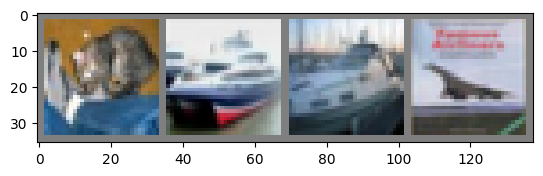

GroundTruth:  cat   ship  ship  plane
Predicted:  bird  horse frog  ship 


In [118]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [119]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %


# ResNet-18

In [25]:
resnet18 = torchvision.models.resnet18(weights='IMAGENET1K_V1')

In [26]:
# É preciso adequar os transformers para os que são usados na rede resnet18

transform = torchvision.models.ResNet18_Weights.IMAGENET1K_V1.transforms

trainset.transform = transform()
testset.transform = transform()

In [27]:
for param in resnet18.parameters():
  param.requires_grad = False

num_ftrs = resnet18.fc.in_features # 512

# Parameters of newly constructed modules have requires_grad=True by default
resnet18.fc = nn.Linear(num_ftrs, 10)

criterion = nn.CrossEntropyLoss().to(device)

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(resnet18.fc.parameters(), lr=0.001, momentum=0.9)

In [28]:
EPOCHS = 1

epoch_losses = []
resnet18 = resnet18.to(device)
for epoch in range(EPOCHS):  # loop over the dataset multiple times

  running_loss = 0.0
  epoch_loss = 0.0

  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = resnet18(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    epoch_loss += outputs.shape[0] * loss.item()
    if i % 2000 == 1999:    # print every 2000 mini-batches
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
      running_loss = 0.0

  epoch_loss_mean = epoch_loss / len(trainset)
  print(f"[epoch {epoch + 1}] loss: {epoch_loss_mean:.3f}")
  epoch_losses.append(epoch_loss_mean)

print('Finished Training')

[1,  2000] loss: 1.482
[1,  4000] loss: 1.285
[1,  6000] loss: 1.237
[1,  8000] loss: 1.231
[1, 10000] loss: 1.228
[1, 12000] loss: 1.231
[epoch 1] loss: 1.282
Finished Training


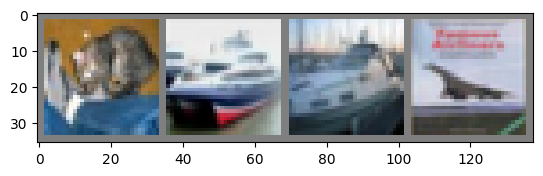

GroundTruth:  cat   ship  ship  plane
Predicted:  bird  car   dog   cat  


In [16]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [21]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data

        labels = labels.to(device)
        images = images.to(device)

        # calculate outputs by running images through the network
        outputs = resnet18(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 24 %
